<a href="https://colab.research.google.com/github/katduecker/dnn_osci/blob/main/DynANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### settings & clone github

In [1]:
# # mount google drive
# from google.colab import drive
# drive.mount('/content/drive')

# # clone github
# !git clone https://github.com/katduecker/dnn_osci

# # enter folder
#%cd dnn_osci

%cd aet_pytorch/

fig_pth = '/Users/katharinaduecker/Documents/projects_uob/dyn_ann/plos comp biol/figures/'

load_NN = False     # load pre-trained NN? - note that the parameters defining the dynamics have to be adapted for newly trained networks
save_NN = False       # save trained NN?

/Users/katharinaduecker/Documents/projects_uob/dyn_ann/dnn_osci/aet_pytorch


In [2]:
# import packages

import torch
from torch import nn
import numpy as np

# get CUDA index
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# colours for plot
col = mcolors.TABLEAU_COLORS

from itertools import combinations

import scipy

from matplotlib.patches import Rectangle


import aet_net_2lay       # 2-layer architecture
from aet_net import sigmoid
from aet_dyn import euler_dyn, euler_dyn_2layer, fun_fixed_point_num


from scipy.optimize import fsolve
import scipy


## Concept figure

In [ ]:
## Concept figure 1

from aet_figures import fig1

fig_1 = fig1()

## Train or load network

In [15]:
nn_dim_ = [28,64,32,3]   # [quadrant size, number of hidden nodes, number of output nodes]
eta_ = 4e-4           # learning rate
mini_sz_ = 1          # mini batch size (1 = use SGD)
num_epo_ = 30

beta_ = 0
p_ = .02              # has to be != 0 even if not used
kl_reg_ = [beta_,p_,1]#[0,0.001] # sparsity constraint parameters (not used for manual model)
sig_param =[[2, -2.5, False],[2, -2.5, False]] # sigmoid slope and shift in x direction

ortho_lmbda = 0
ortho_layer = 2

# loss function & final layer activation (for binary crossentropy use sigmoid)
lossfun = [nn.MSELoss(), nn.Softmax(dim=-1)]   # also shown in supp: lossfun = [nn.CrossEntropyLoss(), nn.Softmax(dim=-1)]


params = nn_dim_,eta_,mini_sz_,num_epo_,kl_reg_,sig_param,ortho_lmbda,ortho_layer

# create stimuli

x_train, y_train = aet_net_2lay.aet_stim.mkstim()
x_train = x_train.to(DEVICE)
y_train = y_train.to(DEVICE)


if load_NN:
  model2 = torch.load("model_2layer.pt")
  loss_hist2 = torch.load("loss_epoch.pt")
else:

  # initialize model and weights
  model2 = aet_net_2lay.net(params,lossfun)
  model2 = aet_net_2lay.init_params(model2,weight_init='uni')

  optimizer = torch.optim.Adam(model2.parameters(),lr=eta_)

  model2.to(DEVICE)
  loss_hist2 = model2.train(optimizer,noise=False,print_loss=False)


if save_NN:
  torch.save(model2,"model_2layer.pt")
  torch.save(loss_hist2,"loss_epoch.pt")

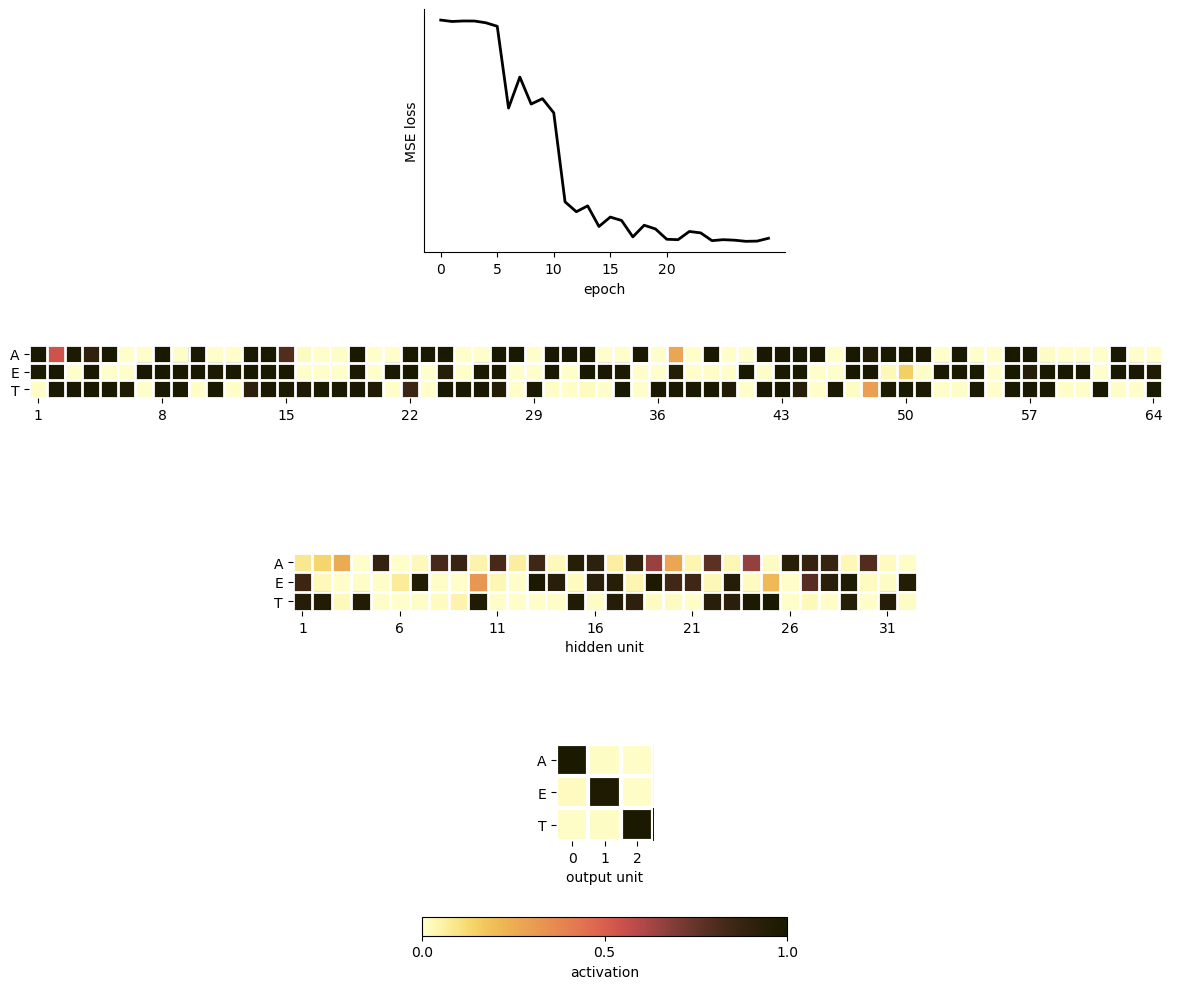

In [16]:
# plot network activations

Z21,H21,H22,O2 = model2.forw_conv(x_train)   # get the hidden layer activations for plotting

# inputs
loss_hist2 = loss_hist2.detach().cpu()
from aet_figures import fig2

# prepare labels
idx = np.array((0,4,8))
label = ['A','E','T']

fig_2 = fig2(loss_hist2,idx,label,H21,H22,O2)

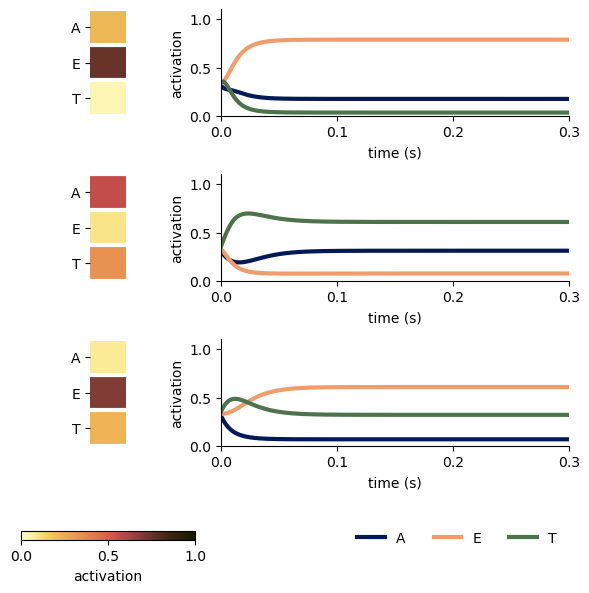

In [17]:
# show how it fails when presented with two stimuli

from aet_figures import fig5

idx = np.array((0,5,10))#,-1))
inp_combi = list(combinations(idx,2)) 
label = ['A','E','T']
fig_5 = fig5(x_train,model2,idx,label)


## Explore parameters c & S

/Users/katharinaduecker/Documents/projects_uob/dyn_ann/dnn_osci/aet_pytorch/aet_net.py:17: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-_slope*(z+_bias)))


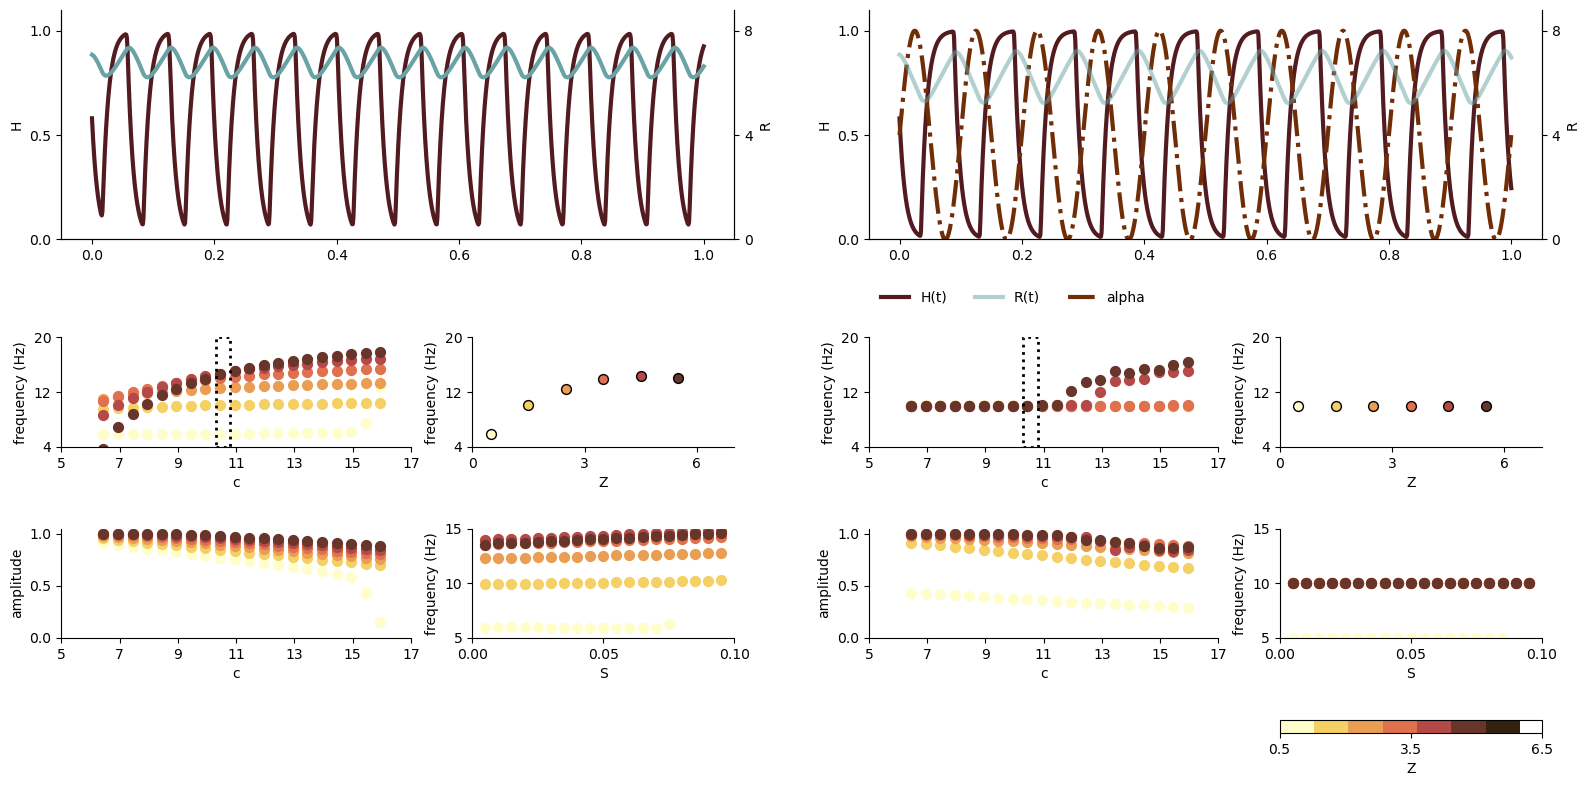

In [18]:
from aet_figures import fig3

# get all Z's for all inputs
Zall = model2.forw_conv(x_train)[0]

# find maximum
maxZ = torch.max(Zall[:])
Z = torch.max(Zall[:]).detach().numpy()

Z_vec = np.arange(0.5,Z,1)

# dynamics parameters
tau_h = 0.01
tau_R = 0.1
a = 2
S = 0.05
# fix c
c = 11

params = [tau_h,tau_R,c,S]

# explore range of values for c and S depending on activation Z
c_vec = np.arange(Z,2.5*Z,.5)
S_vec = np.arange(0.005,0.1,0.005)

# parameters for inhibition ogg
alpha_freq = 10
alpha_amp = 0
alpha_phs = 0
alpha_params_off = [alpha_freq,alpha_amp,alpha_phs]

# parameters for inhibition on
alpha_amp = 0.5
alpha_params_on = [alpha_freq,alpha_amp,alpha_phs]

fig_3, peaks_r, troughs_r = fig3(Z,Z_vec,c_vec,S_vec,params,alpha_params_off,alpha_params_on)

mean_rise_r = np.mean(troughs_r[:-1] - peaks_r)     # mean rise time of R with this combination of tau_R and c


In [ ]:
mean_rise_r

## Dynamics single input

start dynamics at fixed points for Z = 4

$R = \frac{c}{c-1}Z$ and
$H = \frac{Z}{c-1}$

In [19]:
# get all hidden activations without dynamics

Z21,H1,H2,O = model2.forw_conv(x_train[0])
Z22 = model2.fc1(H1)
H1 = H1.detach().cpu().numpy()
H2 = H2.detach().cpu().numpy()
O = O.detach().cpu().numpy()


In [ ]:
# Dynamics parameters
tau_h = 0.01
tau_R = 0.1
S = .05
c = 10

t_start = 0     # when stimulus presented
t = 0             # when to begin plot

params = [tau_h,tau_R,c,S]


In [20]:
## Dynamics one input

## without alpha inhibition
# alpha parameters
afreq = [10,10]
aamp = [0,0]
aph = [2*np.pi/100 * 20,0]#[np.pi+2*np.pi/100 * 10,np.pi]


alpha_params = [afreq,aamp,aph]

timevec = np.linspace(0,1,1000)

# get time course of Z (pre-activation), H, R, and O (output)
Z1t,Z2t,H1t,R1t, H2t, R2t, Ot = euler_dyn_2layer(model2,x_train[0],params,timevec,alpha_params,DEVICE,t_start,start_fix=True)

## with alpha inhibition
# alpha parameters
afreq = [10,10]
aamp = [0.5,.5]
aph = [0,0]   # no phase shift between layers

alpha_params = [afreq,aamp,aph]

timevec = np.linspace(0,1,1000)

# get time course of Z (pre-activation), H, R, and O (output)
# with alpha inhibition
Z1ta,Z2ta,H1ta,R1ta, H2ta, R2ta, Ota = euler_dyn_2layer(model2,x_train[0],params,timevec,alpha_params,DEVICE,t_start,start_fix=True)


# find fixed points numerically

# layer 1
Z = Z21.detach().cpu()

Hstar1 = np.zeros_like(Z)
Rstar1 = np.zeros_like(Z)
for i,z in enumerate(Z):
  # fixed point
  Hstar1[i] = fsolve(fun_fixed_point_num,0.001,args=(z,c,S))[0]
  Rstar1[i] = c*Hstar1[i]

# layer 2
Z = Z22.detach().cpu()

# the fixed points for alpha are not stable
Hstar2 = np.zeros_like(Z)
Rstar2 = np.zeros_like(Z)
for i,z in enumerate(Z):
  # fixed point
  Hstar2[i] = fsolve(fun_fixed_point_num,0.001,args=(z,c,S))[0]
  Rstar2[i] = c*Hstar2[i]

/Users/katharinaduecker/Documents/projects_uob/dyn_ann/dnn_osci/aet_pytorch/aet_dyn.py:151: RuntimeWarning: invalid value encountered in log
  return (Z/(c-1))+(S/(c-1))*(np.log(1/x-1)/2-2.5)-x
/var/folders/7z/wfcp96210zb700801j0vcbmw0000gn/T/ipykernel_11376/473496693.py:53: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Hstar1[i] = fsolve(fun_fixed_point_num,0.001,args=(z,c,S))[0]
/var/folders/7z/wfcp96210zb700801j0vcbmw0000gn/T/ipykernel_11376/473496693.py:64: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Hstar2[i] = fsolve(fun_fixed_point_num,0.001,args=(z,c,S))[0]


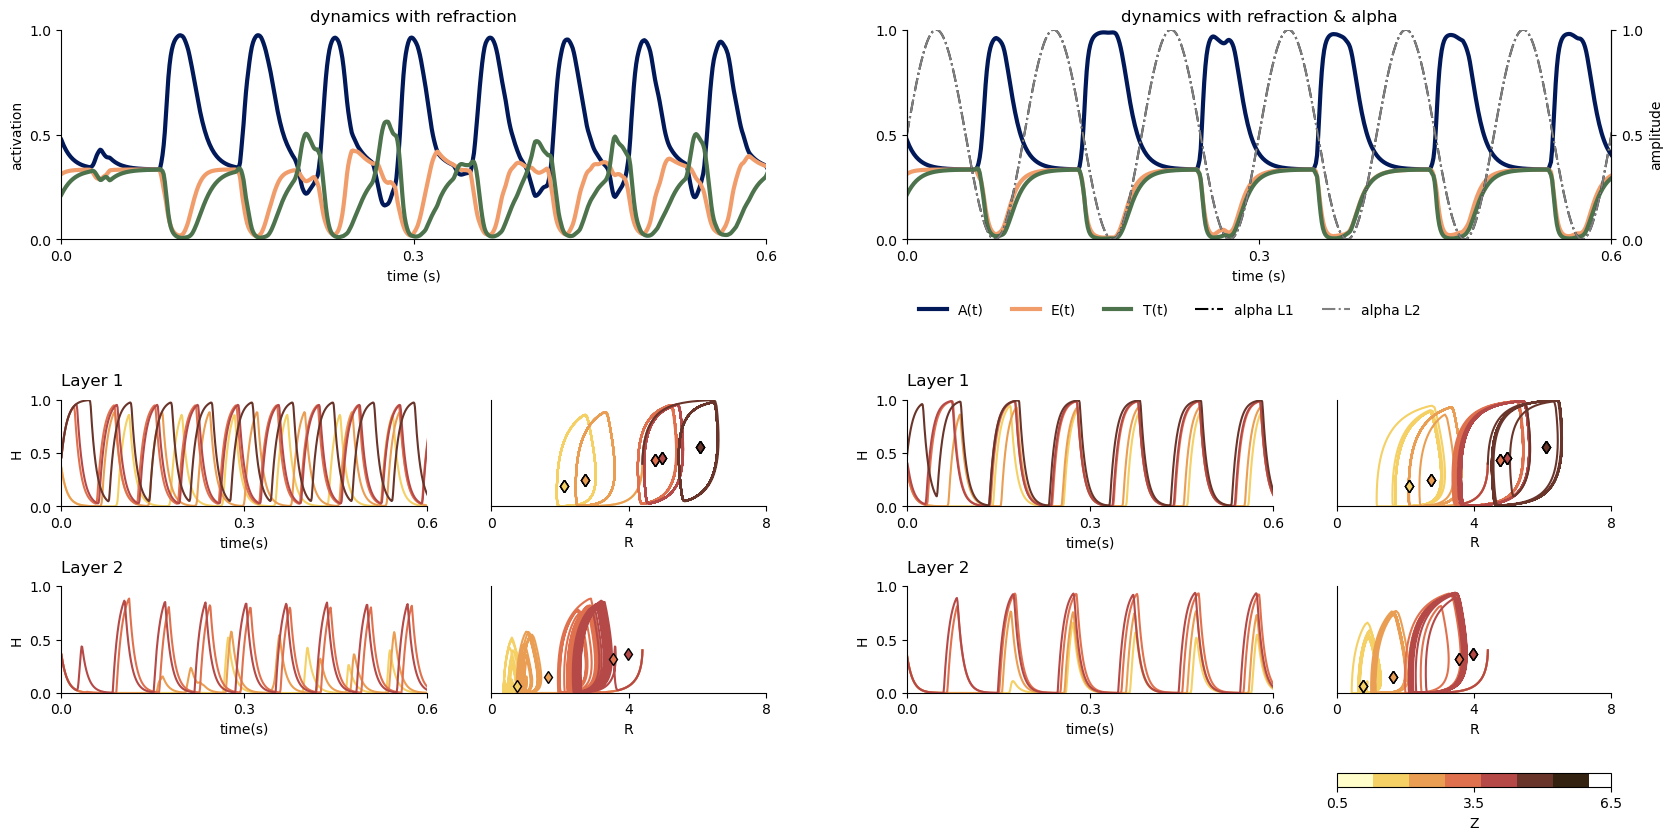

In [21]:
# plot
from aet_figures import fig4
fig_4 = fig4(timevec,alpha_params,t_start,x_train,model2,Z21,Z22,H1t,Hstar1,H1ta,H2t,H2ta,Hstar2,R1t,Rstar1,R1ta,R2t,R2ta,Rstar2,Ot,Ota)

## Dynamics two inputs

In [22]:
# parameters for integration
timevec = np.linspace(0,1,1000)

t_start = 0     # when stimulus presented
t = 0             # when to begin plot

params = [tau_h,tau_R,c,S]


# E & A

inpt = x_train[5]*1.2 + x_train[0]*.8

# without alpha

afreq = [10,10]
aamp = [0,0]
aph = [0,0] # phase lag = 0 between layers


alpha_params = [afreq,aamp,aph]

# time course of output for E & A
OtEA = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params,DEVICE,t_start,start_fix=True)[-1]


# with alpha

afreq = [10,10]
aamp = [0.5,0.5]
aph = [0,0]


alpha_params = [afreq,aamp,aph]

OtaEA = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params,DEVICE,t_start,start_fix=True)[-1]



# E & T

inpt = x_train[6]*1.2 + x_train[-1]*.8

# without alpha
afreq = [10,10]
aamp = [0,0]
aph = [0,0]


alpha_params = [afreq,aamp,aph]

OtET = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params,DEVICE,t_start,start_fix=True)[-1]



# with alpha

afreq = [10,10]
aamp = [0.5,0.5]
aph = [0,0]#[np.pi+2*np.pi/100 * 10,np.pi]


alpha_params = [afreq,aamp,aph]

OtaET = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params,DEVICE,t_start,start_fix=True)[-1]

# A & T

inpt = x_train[0]*1.2 + x_train[-1]*.8

# without alpha
afreq = [10,10]
aamp = [0,0]
aph = [0,0]


alpha_params = [afreq,aamp,aph]

OtAT = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params,DEVICE,t_start,start_fix=True)[-1]



# with alpha

afreq = [10,10]
aamp = [0.5,0.5]
aph = [0,0]#[np.pi+2*np.pi/100 * 10,np.pi]


alpha_params = [afreq,aamp,aph]

OtaAT = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params,DEVICE,t_start,start_fix=True)[-1]


In [23]:
# find period of activation in output (-> corresponds to visual gamma oscillations)
slope_sign = np.sign(np.diff(OtaEA[0][np.where((OtaEA[0].numpy() >= 0.4))]))

first_half = []
second_half = []
for i,s in enumerate(slope_sign[:-1]):
    if s == 1 and slope_sign[i+1] == -1:
        first_half.append(i)
    if s ==-1 and slope_sign[i+1] == 1:
        second_half.append(i)

l_period_activation = np.array(second_half) - np.array(first_half) + np.array(first_half[0])


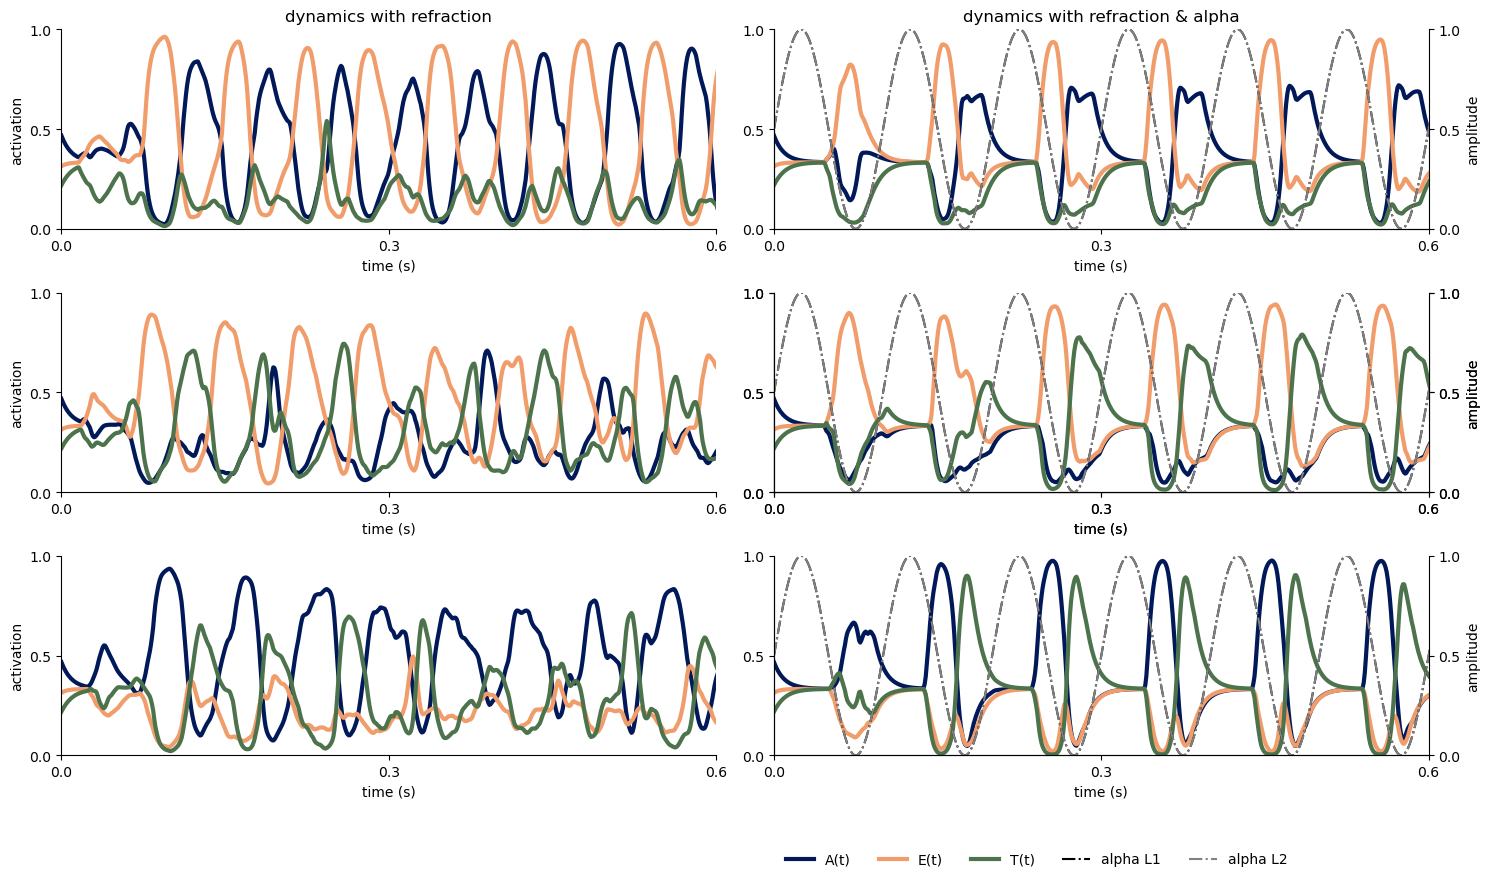

In [24]:
# PLOT

# prepare layout
from aet_figures import fig6

# make a gridplot for all 3 combinations with and without alpha
fig_6 = fig6(timevec,t,alpha_params,OtEA,OtaEA,OtET,OtaET,OtAT,OtaAT)

fig_6.savefig(fig_pth + 'fig6_two_inputs.svg')

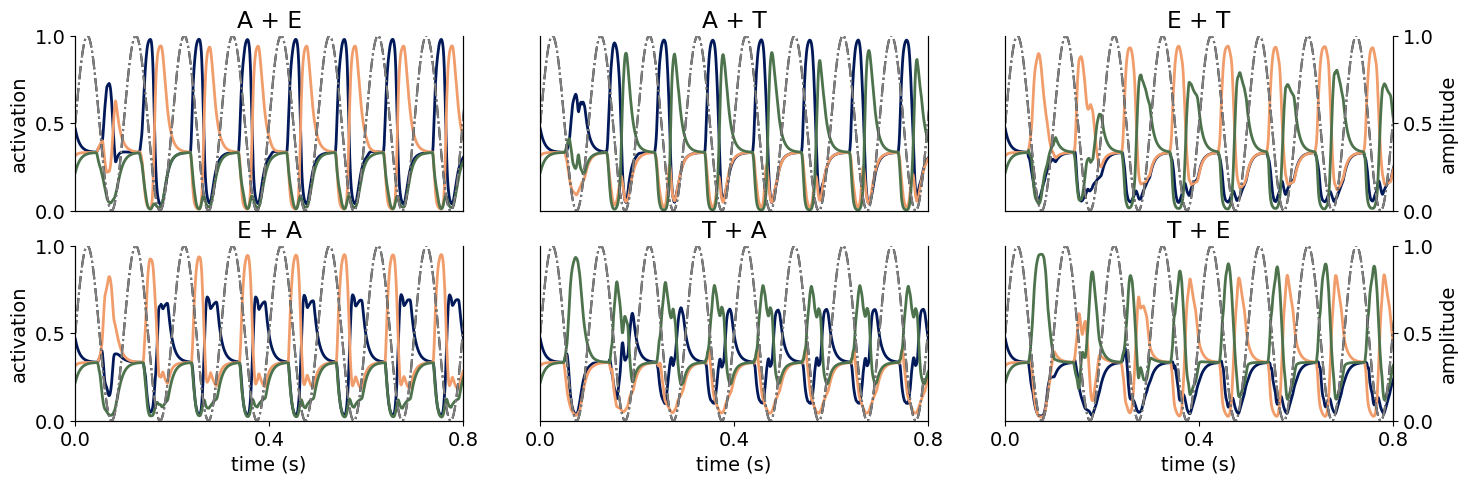

In [32]:
# try other combinations of inputs

t_start = 0     # when stimulus presented
t = 0             # when to begin plot

params = [tau_h,tau_R,c,S]

# alpha parameters
afreq = [10,10]
aamp = [0.5,0.5]
aph = [0,0]#[np.pi+2*np.pi/100 * 10,np.pi]

alpha_params = [afreq,aamp,aph]

timevec = np.linspace(0,1,1000)

idx = np.array((0,5,10))#,-1))


labels = ['A', 'E', 'T']

from aet_figures import supp_fig1

supp_fig_1 = supp_fig1(x_train,model2,timevec,t_start,t,params,alpha_params,idx,labels)



### Phase delay between layers

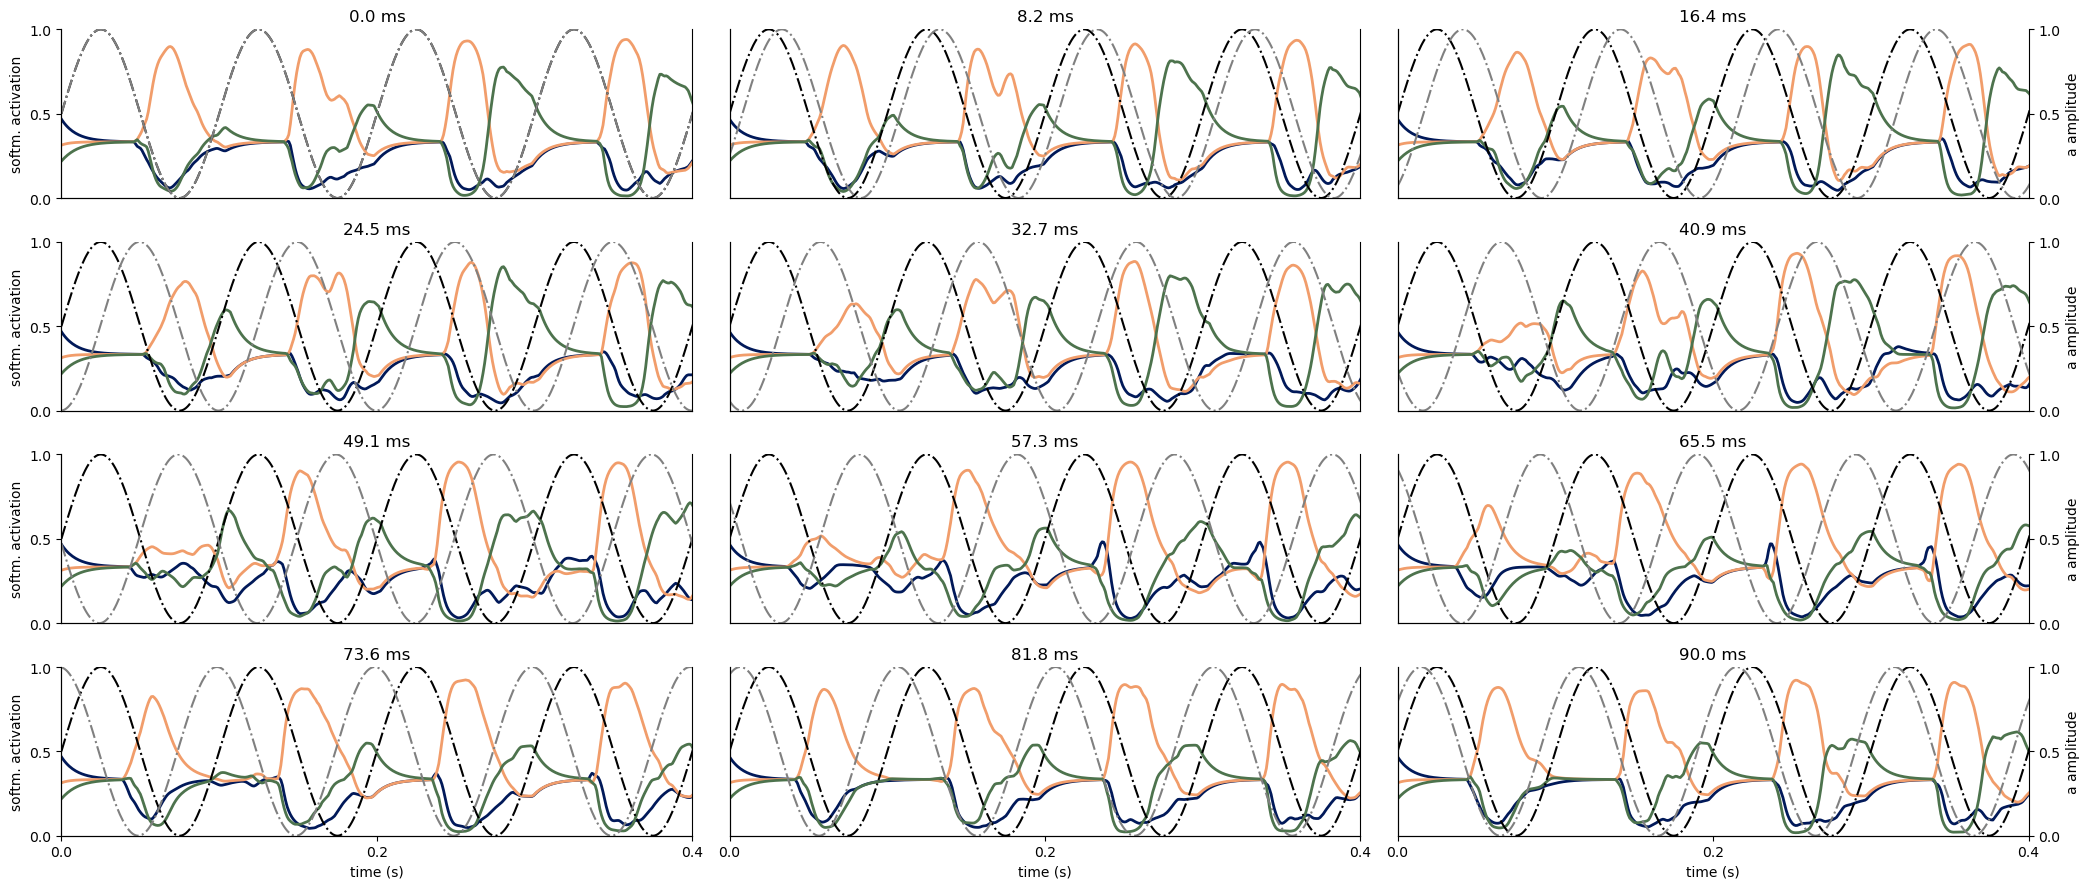

In [26]:
idx_stim = [6,-1]
inpt = x_train[idx_stim[0]]*1.2 + x_train[idx_stim[1]]*.8

ph_diff = np.linspace(0,2*np.pi - (2*np.pi/100)*10,12)

# Dynamics two inputs

t_start = 0     # when stimulus presented
t = 0             # when to begin plot

params = [tau_h,tau_R,c,S]

# alpha parameters
afreq = [10,10]
aamp = [0.5,0.5]

alpha_params = [afreq,aamp]

from aet_figures import fig8

fig_8 = fig8(timevec,t_start,t,inpt,model2,params,alpha_params,ph_diff)

fig_8.savefig(fig_pth + 'phase_diff_all.svg')


### Segregation/Multiplexing along layers

In [27]:
# get non-dynamic activation for hidden representations
_,H1,H2,O = model2.forw_conv(x_train)

t_start = 0     # when stimulus presented
t = 0             # when to begin plot

params = [tau_h,tau_R,c,S]

# alpha parameters
afreq = [10,10]
aamp = [.5,.5]
aph = [0,0]#[np.pi+2*np.pi/100 * 10,np.pi]

alpha_params = [afreq,aamp,aph]

idx_stim = [6, -1]          # select E & T
inpt = x_train[idx_stim[0]]*1.2 + x_train[idx_stim[1]]*.8

Z1t,Z2t,H1t,R1t,H2t,R2t,Ot = euler_dyn_2layer(model2,inpt, params, timevec, alpha_params,DEVICE,inp_on=t_start,start_fix=True)

# normalized dot product to track similarity to single input

# Layer 1

H1corrA = np.array([(torch.dot(H1t[:,t],H1[0])/torch.dot(H1[0],H1[0])).detach().numpy() for t in range(H1t.shape[1])])
H1corrE = np.array([(torch.dot(H1t[:,t],H1[5])/torch.dot(H1[5],H1[5])).detach().numpy() for t in range(H1t.shape[1])])
H1corrT = np.array([(torch.dot(H1t[:,t],H1[-1])/torch.dot(H1[-1],H1[-1])).detach().numpy() for t in range(H1t.shape[1])])


# Layer 2

H2corrA = np.array([(torch.dot(H2t[:,t],H2[0])/torch.dot(H2[0],H2[0])).detach().numpy() for t in range(H2t.shape[1])])
H2corrE = np.array([(torch.dot(H2t[:,t],H2[5])/torch.dot(H2[5],H2[5])).detach().numpy() for t in range(H2t.shape[1])])
H2corrT = np.array([(torch.dot(H2t[:,t],H2[-1])/torch.dot(H2[-1],H2[-1])).detach().numpy() for t in range(H2t.shape[1])])


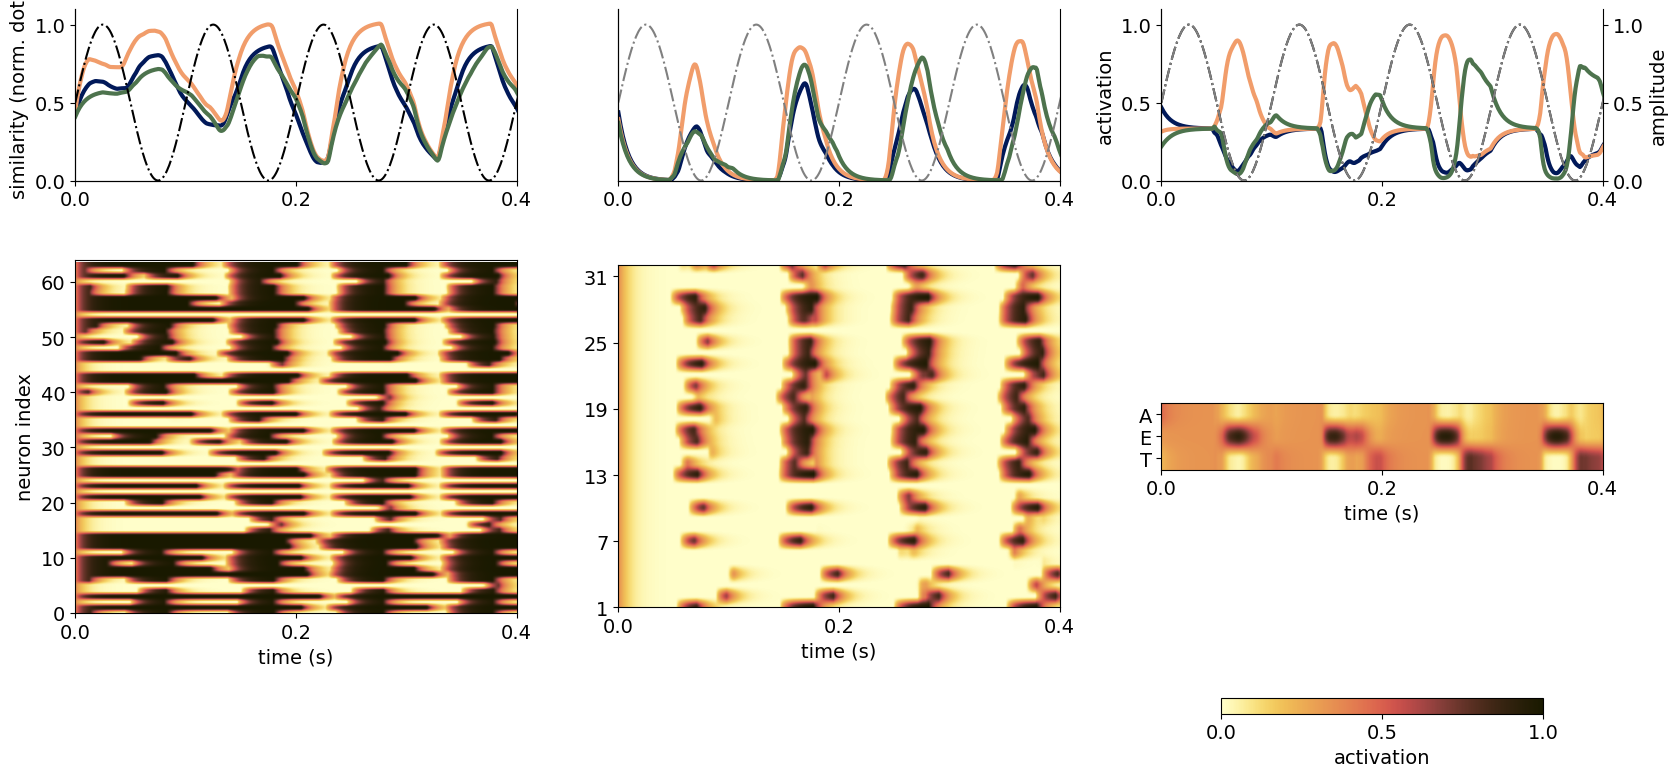

In [28]:
from aet_figures import fig7 
fig_7 = fig7(timevec, t, alpha_params, H1corrA, H1corrE, H1corrT, H1t, H2corrA, H2corrE, H2corrT, H2t, Ot)

fig_7.savefig(fig_pth + 'fig7_segregation.svg')

### Speed up dynamics

In [29]:

# parameters for integration
timevec = np.linspace(0,1,1000)

t_start = 0     # when stimulus presented
t = 0             # when to begin plot

params = [tau_h,tau_R,c,S]


# E & A

inpt = x_train[5]*1.2 + x_train[0]*.8

# without alpha

afreq = [10,10]
aamp = [0,0]
aph = [0,0] # phase lag = 0 between layers


alpha_params = [afreq,aamp,aph]

# time course of output for E & A
OtEA = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params,DEVICE,t_start,start_fix=True)[-1]


# with alpha

afreq = [10,10]
aamp = [0.5,0.5]
aph = [0,0]


alpha_params = [afreq,aamp,aph]

OtaEA = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params,DEVICE,t_start,start_fix=True)[-1]



# E & T

inpt = x_train[6]*1.2 + x_train[-1]*.8

# without alpha
afreq = [10,10]
aamp = [0,0]
aph = [0,0]


alpha_params = [afreq,aamp,aph]

OtET = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params,DEVICE,t_start,start_fix=True)[-1]



# with alpha

afreq = [10,10]
aamp = [0.5,0.5]
aph = [0,0]#[np.pi+2*np.pi/100 * 10,np.pi]


alpha_params = [afreq,aamp,aph]

OtaET = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params,DEVICE,t_start,start_fix=True)[-1]

# A & T

inpt = x_train[0]*1.2 + x_train[-1]*.8

# without alpha
afreq = [10,10]
aamp = [0,0]
aph = [0,0]


alpha_params = [afreq,aamp,aph]

OtAT = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params,DEVICE,t_start,start_fix=True)[-1]



# with alpha

afreq = [10,10]
aamp = [0.5,0.5]
aph = [0,0]#[np.pi+2*np.pi/100 * 10,np.pi]


alpha_params = [afreq,aamp,aph]

OtaAT = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params,DEVICE,t_start,start_fix=True)[-1]

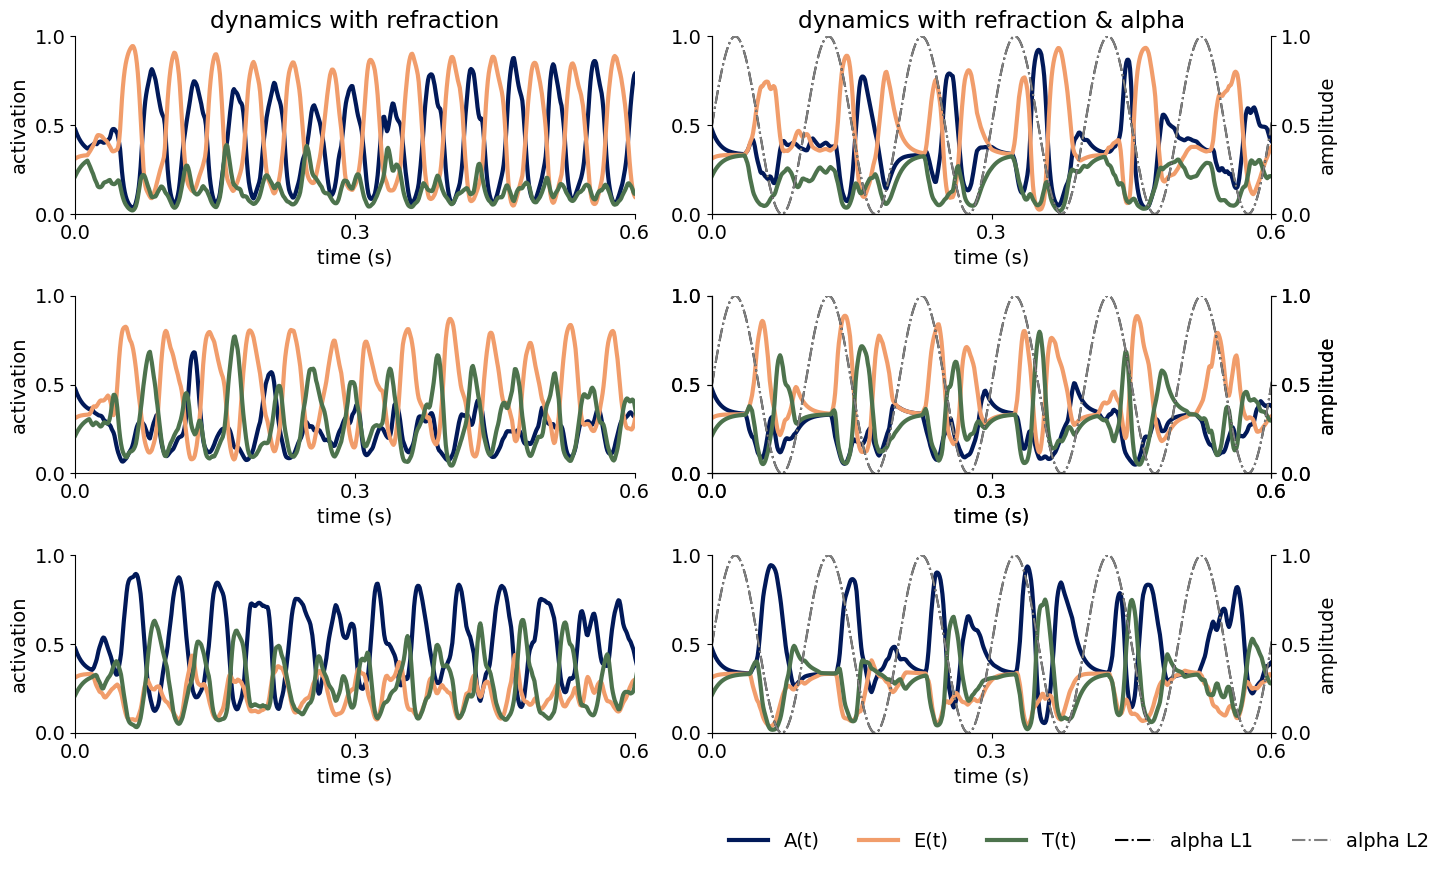

In [30]:
fig_6 = fig6(timevec,t,alpha_params,OtEA,OtaEA,OtET,OtaET,OtAT,OtaAT)

fig_6.savefig(fig_pth + 'supp_fig2_faster_dynamics.svg')

### Slow down inhibition

In [ ]:
# parameters for integration
timevec = np.linspace(0,1,1000)

t_start = 0     # when stimulus presented
t = 0             # when to begin plot

params = [tau_h,tau_R,c,S]


# E & A

inpt = x_train[5]*1.2 + x_train[0]*.8

# without alpha

afreq = [10,10]
aamp = [0,0]
aph = [0,0] # phase lag = 0 between layers


alpha_params = [afreq,aamp,aph]

# time course of output for E & A
OtEA = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params,DEVICE,t_start,start_fix=True)[-1]


# with alpha

afreq = [7,7]
aamp = [0.8,0.8]
aph = [0,0]


alpha_params = [afreq,aamp,aph]

OtaEA = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params,DEVICE,t_start,start_fix=True)[-1]



# E & T

inpt = x_train[6]*1.2 + x_train[-1]*.8

# without alpha
afreq = [10,10]
aamp = [0,0]
aph = [0,0]


alpha_params = [afreq,aamp,aph]

OtET = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params,DEVICE,t_start,start_fix=True)[-1]



# with alpha

afreq = [7,7]
aamp = [0.8,0.8]
aph = [0,0]#[np.pi+2*np.pi/100 * 10,np.pi]


alpha_params = [afreq,aamp,aph]

OtaET = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params,DEVICE,t_start,start_fix=True)[-1]

# A & T

inpt = x_train[0]*1.2 + x_train[-1]*.8

# without alpha
afreq = [7,7]
aamp = [0,0]
aph = [0,0]


alpha_params = [afreq,aamp,aph]

OtAT = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params,DEVICE,t_start,start_fix=True)[-1]



# with alpha

afreq = [7,7]
aamp = [0.8,0.8]
aph = [0,0]#[np.pi+2*np.pi/100 * 10,np.pi]


alpha_params = [afreq,aamp,aph]

OtaAT = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params,DEVICE,t_start,start_fix=True)[-1]

In [ ]:
fig_6 = fig6(timevec,t,alpha_params,OtEA,OtaEA,OtET,OtaET,OtAT,OtaAT)

fig_6.savefig(fig_pth + 'supp_fig4_slower_alpha.svg')

In [ ]:
# 3 Simultaneous stimuli

# parameters for integration
timevec = np.linspace(0,1,1000)

t_start = 0     # when stimulus presented
t = 0             # when to begin plot

params = [tau_h,tau_R,c,S]

inpt = x_train[5]*1.2 + x_train[0]*1. + x_train[-1]*.8


# without alpha

afreq = [10,10]
aamp = [0,0]
aph = [0,0] # phase lag = 0 between layers


alpha_params = [afreq,aamp,aph]

# time course of output for E & A
Ot3slow = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params,DEVICE,t_start,start_fix=True)[-1]


# with alpha

afreq = [10,10]
aamp = [0.5,0.5]
aph = [0,0]


alpha_params_og = [afreq,aamp,aph]

Ota3slow = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params_og,DEVICE,t_start,start_fix=True)[-1]


# speed up dynamics
tau_h = 0.01
tau_R = 0.1
S = .01
c = 10

t_start = 0     # when stimulus presented
t = 0             # when to begin plot

params = [tau_h,tau_R,c,S]

inpt = x_train[5]*1.2 + x_train[0]*1. + x_train[-1]*.8


# without alpha

afreq = [10,10]
aamp = [0,0]
aph = [0,0]


alpha_params = [afreq,aamp,aph]

# time course of output for E & A
Ot3fast = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params,DEVICE,t_start,start_fix=True)[-1]


# with alpha

afreq = [7,7]
aamp = [.8,.8]
aph = [0,0]


alpha_params_new = [afreq,aamp,aph]

Ota3fast = euler_dyn_2layer(model2,inpt,params,timevec,alpha_params_new,DEVICE,t_start,start_fix=True)[-1]



from aet_figures import supp_fig3
supp_fig_3 = supp_fig3(timevec,t,alpha_params_og,alpha_params_new,Ot3slow,Ota3slow,Ot3fast,Ota3fast)

fig_6.savefig(fig_pth + 'supp_fig3_3inpts.svg')
